In [75]:
from random import randrange
from scipy.stats import ttest_ind, ttest_1samp
import numpy as np
import matplotlib.pyplot as plt
import random

In [76]:
diet = [randrange(8,14) for _ in range(13)]
nodiet = [randrange(7,18) for _ in range(15)]

print(f"""
The people who followed the diet had the following apnea events: {diet}, 
While those who didn't follow the diet had the following apnea events: {nodiet}.
""")


The people who followed the diet had the following apnea events: [8, 13, 12, 13, 11, 11, 13, 13, 9, 12, 9, 11, 13], 
While those who didn't follow the diet had the following apnea events: [12, 11, 14, 14, 12, 14, 13, 10, 9, 13, 13, 13, 12, 12, 7].



In [77]:
res = ttest_ind(diet, nodiet, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.5f}')

p-value for single sided test: 0.22221


## Permutation test

Write your own Python implementation of a permutation test to generate 1,000 resamples; in each iteration perform a one-sided t-test and record the p-value.

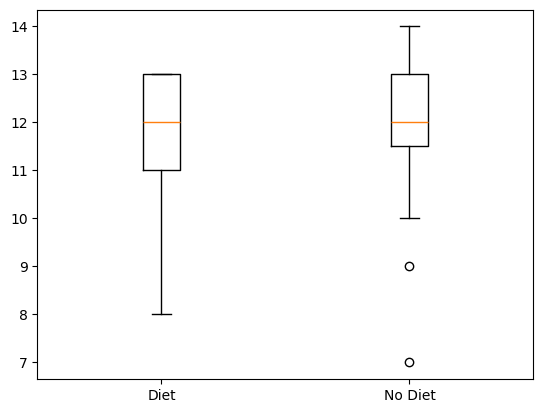

In [78]:
import pandas as pd

treatment = ['diet'] * len(diet)
treatment.extend(['nodiet'] * len(nodiet))

df = pd.DataFrame({'treatment': treatment, 'n_events': diet + nodiet})
# df
plt.boxplot([diet, nodiet], labels=['Diet', 'No Diet'])
plt.show()

In [79]:
mean_diet = df[df.treatment == 'diet'].n_events.mean()
mean_nodiet = df[df.treatment == 'nodiet'].n_events.mean()
observed_difference = mean_nodiet - mean_diet
observed_difference

0.5487179487179485

In [80]:
def perm_func(df):
    df = df.copy()
    n_diet = df[df.treatment == 'diet'].n_events.shape[0]
    n_nodiet = df[df.treatment == 'nodiet'].n_events.shape[0]
    n = n_diet + n_nodiet
    idx_diet = set(random.sample(range(n), n_diet))  #  note we're permuting indices, not values
    idx_nodiet = set(range(n)) - idx_diet       #  the set of indices for nodiet is created by removing all indices that are assigned to diet
    return df.n_events.loc[list(idx_diet)].mean() - df.n_events.loc[list(idx_nodiet)].mean() 

diffs = [perm_func(df) for _ in range(2000)]

# we want to know how often the sample mean is greater than the difference in mean[diet] - mean[nodiet]
# so this is a proportion of Trues in the array
p_value = np.mean(np.array(diffs) > observed_difference)
p_value

0.248

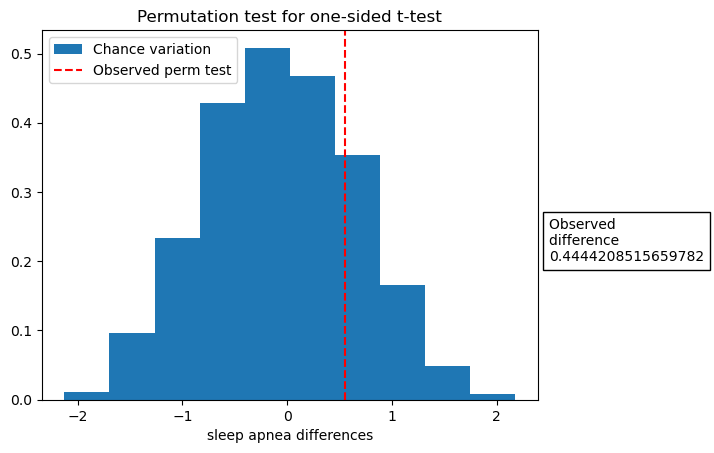

In [100]:
# plt.figure(figsize=(10,10))
plt.hist(diffs, label='Chance variation', density=True)
plt.axvline(observed_difference, linestyle='--', c='r', label='Observed perm test')
# plt.axhline(res.pvalue / 2, linestyle=':', c='r', label='Observed scipy ttest') # the y-axis represents the probability density, not the p-value
plt.title('Permutation test for one-sided t-test')
plt.xlabel('sleep apnea differences')
plt.text(2.5,0.2, f'Observed \ndifference \n{p_value}', bbox={'facecolor':'white'})
plt.legend()
plt.show()

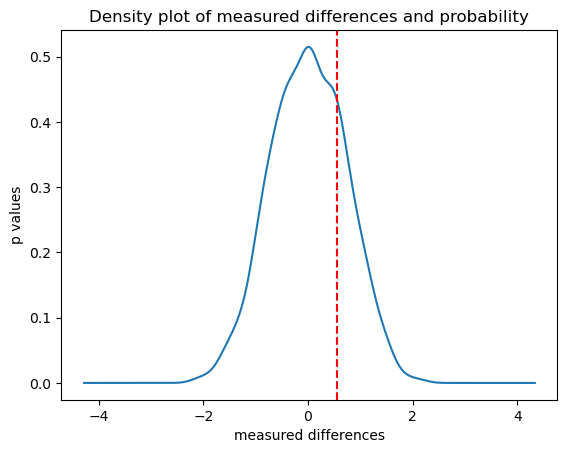

In [98]:
ax = pd.Series(diffs).plot.density()
ax.axvline(observed_difference, linestyle='--', c='r', label='Observed perm test')
plt.title('Density plot of measured differences and probability')
plt.xlabel("measured differences")
plt.ylabel("p values")
plt.show()

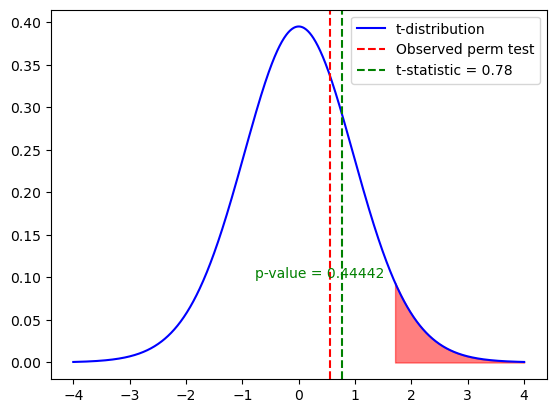

In [108]:
from scipy.stats import t

t_stat, p_value = ttest_ind(diet, nodiet, equal_var=False)
df = len(diet) + len(nodiet) - 2

x = np.linspace(-4, 4, 1000)
y = t.pdf(x, df)

plt.plot(x, y, 'b-', label='t-distribution')
plt.axvline(observed_difference, linestyle='--', c='r', label='Observed perm test')

# Critical regions for alpha = 0.05
alpha = 0.05
critical_value = t.ppf(1 - alpha, df) # normally alpha / 2 (two-tailed)
plt.fill_between(x, 0, y, where=(x >= critical_value), color='red', alpha=0.5) # type: ignore
# plt.fill_between(x, 0, y, where=(x <= -critical_value), color='red', alpha=0.5) # type: ignore


plt.axvline(-t_stat, color='green', linestyle='--', label=f't-statistic = {-t_stat:.2f}')
plt.text(t_stat, 0.1, f'p-value = {p_value:.5f}', color='green')

# Mark the test statistic
plt.legend()
plt.show()